In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from ast import literal_eval
import statistics
import scipy.stats as sp

In [6]:
df = pd.read_csv("ms_results/PRS_calculations_v4_discovery_0.7_nobootstrap", sep=" ", header=None, converters={9: literal_eval, 10: literal_eval, 11: literal_eval, 12: literal_eval}) 
phen_list = ['phenotype']
anc_list = df[2].unique().tolist()
anc_list = ['African', 'WHG', 'EHG', 'CHG', 'Yamnaya','Farmer','EastAsian']
anc_list = ['Steppe', 'CHG', 'EHG', 'WHG', 'Farmer', 'African']

exclude_mhc = False
only_MHC = False

results_df = pd.DataFrame(columns=['phenotype', 'ancestry', 'PRS'])
for phen in phen_list:
    df1 = df[df[1]==phen]
    dict_of_PRS = dict()
    maf_df_all = pd.DataFrame()
    for n,anc in enumerate(anc_list):
        df2 = df1.loc[(df1[2]==anc)&(df1[8]==0)]
        maf_list = list()
        beta_list = list()
        position_list = list()
        chr_list = list()
        for i in range(1,23):
            try:
                maf_list += df2.loc[(df2[3]==i)][10].item()
                beta_list += df2.loc[(df2[3]==i)][11].item()
                position_list += [int(x) for x in df2.loc[(df2[3]==i)][12].item()]
                chr_list += [str(i) for x in df2.loc[(df2[3]==i)][12].item()]
            except ValueError:
                continue
        maf_df_all[anc] = maf_list
        if n == len(anc_list)-1:
            maf_df_all['beta'] = beta_list
            maf_df_all['pos'] = position_list
            maf_df_all['chr'] = chr_list
        if exclude_mhc:
            maf_beta = pd.DataFrame([maf_list, beta_list, chr_list, position_list]).T
            maf_beta.columns = ['maf', 'beta', 'chr', 'pos']
            maf_beta = maf_beta.loc[~((maf_beta['pos']>28477797) & (maf_beta['pos']<33448354) & (maf_beta['chr']=='6'))]
        elif only_MHC:
            maf_beta = pd.DataFrame([maf_list, beta_list, chr_list, position_list]).T
            maf_beta.columns = ['maf', 'beta', 'chr', 'pos']
            maf_beta = maf_beta.loc[(maf_beta['pos']>28477797) & (maf_beta['pos']<33448354) & (maf_beta['chr']=='6')]
        else:
            maf_beta = pd.DataFrame([maf_list, beta_list]).T
            maf_beta.columns = ['maf', 'beta']
        maf_beta['meangen'] = maf_beta['maf']*maf_beta['beta']
        dict_of_PRS[anc] = maf_beta['meangen'].sum()
    if exclude_mhc:
        maf_df_all = maf_df_all.loc[~((maf_df_all['pos']>28477797) & (maf_df_all['pos']<33448354) & (maf_df_all['chr']=='6'))]
    elif only_MHC:
        maf_df_all = maf_df_all.loc[(maf_df_all['pos']>28477797) & (maf_df_all['pos']<33448354) & (maf_df_all['chr']=='6')]
    maf_df_all['mean_freq'] = maf_df_all[anc_list].mean(axis=1)
    maf_df_all['score'] = maf_df_all['mean_freq']*(1-maf_df_all['mean_freq'])*(maf_df_all['beta']**2)

    mean_PRS = statistics.mean(list(dict_of_PRS.values()))
    varmean = maf_df_all['score'].sum()

    for anc in anc_list:
#     for anc in ['Farmer', 'Steppe', 'African', 'EHG', 'CHG', 'WHG']: # Can order results here if desired
        meangen = dict_of_PRS[anc] - mean_PRS
        meangenvec = 2 * meangen / (math.sqrt(4*varmean))
        results_df = results_df.append({'phenotype':phen, 'ancestry': anc, 'PRS': meangenvec}, ignore_index=True)
theta = results_df # For accelerated bootstrap below
   

phenotype has 204 SNPs


,ancestry,phenotype,mean,std,sem,std_2,error
0,African,phenotype,-1.153737,0.640875,0.020266,1.281750,0.039722
1,CHG,phenotype,0.300229,0.691968,0.021882,1.383936,0.042889
2,EHG,phenotype,-0.106680,0.446015,0.014104,0.892030,0.027644
3,Farmer,phenotype,-0.753265,0.453189,0.014331,0.906379,0.028089
4,Steppe,phenotype,1.620978,0.850046,0.026881,1.700091,0.052686
5,WHG,phenotype,0.092475,0.591824,0.018715,1.183649,0.036682


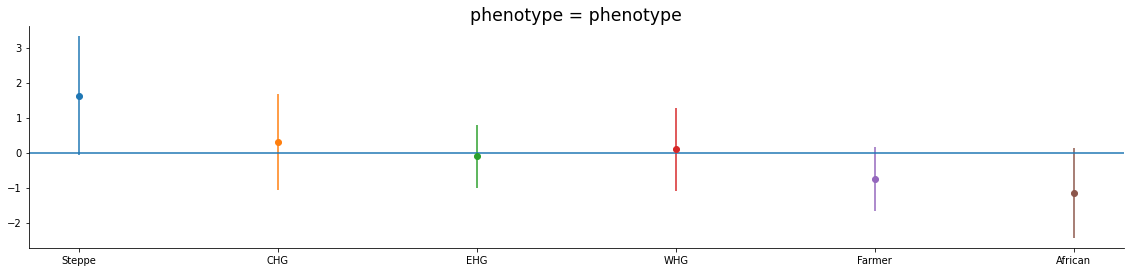

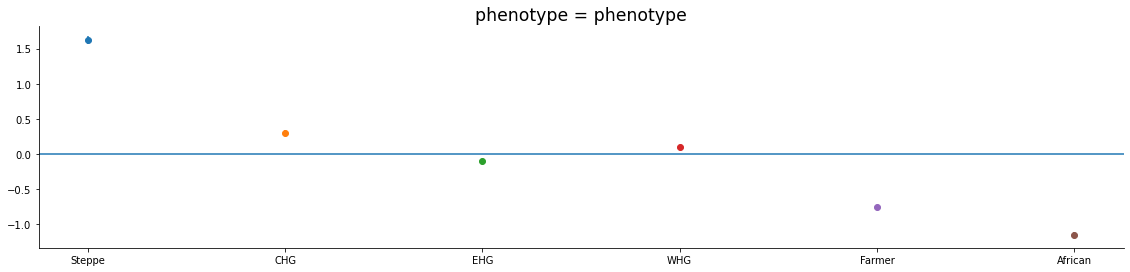

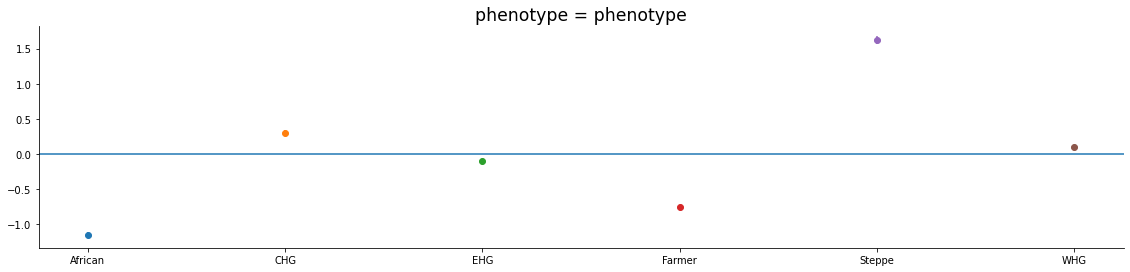

In [7]:
# Bootstrap loci, and plot means with SD
df = pd.read_csv("ms_results/PRS_calculations_v4_discovery_0.7_nobootstrap", sep=" ", header=None, converters={9: literal_eval, 10: literal_eval, 11: literal_eval, 12: literal_eval}) 
phen_list = ['phenotype']
anc_list = df[2].unique().tolist()

exclude_mhc = False
only_MHC = False
boostrap_number = 1000
anc_list = ['African', 'WHG', 'EHG', 'CHG', 'Yamnaya','Farmer','EastAsian']
anc_list = ['Steppe', 'CHG', 'EHG', 'WHG', 'Farmer', 'African']

results_df = pd.DataFrame(columns=['phenotype', 'ancestry', 'PRS'])
for phen in phen_list:
    beta_list = list()
    position_list = list()
    chr_list = list()                             
    for i in range(1,23):
        try:
            beta_list += df.loc[(df[2]=='Farmer')&(df[8]==0)&(df[1]==phen)&(df[3]==i)][11].item()
            position_list += df.loc[(df[2]=='Farmer')&(df[8]==0)&(df[1]==phen)&(df[3]==i)][12].item()
            for x in df.loc[(df[2]=='Farmer')&(df[8]==0)&(df[1]==phen)&(df[3]==i)][11].item():
                chr_list.append(df.loc[(df[2]=='Farmer')&(df[8]==0)&(df[1]==phen)&(df[3]==i)][3].item())
        except ValueError:
            continue
    beta_position_map = pd.DataFrame([beta_list, position_list, chr_list]).T
    beta_position_map.columns = ['beta', 'pos', 'chr']
    print(phen + " has " + str(len(beta_list)) + " SNPs")
    if exclude_mhc:
        beta_position_map_excluded = beta_position_map.loc[~((beta_position_map['pos'].astype(int)>28477797) & (beta_position_map['pos'].astype(int)<33448354) & (beta_position_map['chr']==6))]
        print("Excluding MHC SNPs, now " + str(beta_position_map_excluded.shape[0]) + " SNPs")
    elif only_MHC:
        beta_position_map_excluded = beta_position_map.loc[(beta_position_map['pos'].astype(int)>28477797) & (beta_position_map['pos'].astype(int)<33448354) & (beta_position_map['chr']==6)]
        print("Only including MHC SNPs, now " + str(beta_position_map_excluded.shape[0]) + " SNPs")
    df_beta = pd.DataFrame(beta_list)
    for bs in range(boostrap_number):
        maf_beta=pd.DataFrame()
        if exclude_mhc:
            bootstrap = beta_position_map_excluded.sample(n=beta_position_map_excluded.shape[0], replace=True)
        elif only_MHC:
            bootstrap = beta_position_map_excluded.sample(n=beta_position_map_excluded.shape[0], replace=True)
        else:
            bootstrap = beta_position_map[['beta', 'pos', 'chr']].sample(n=beta_position_map.shape[0], replace=True)
        dict_of_PRS = dict()
        maf_df_all = pd.DataFrame()
        for anc in anc_list:
            df1 = df.loc[(df[1]==phen)&(df[8]==0)&(df[2]==anc)]
            maf_list = list()
            for i in range(1,23):
                try:
                    maf_list += df1.loc[(df1[3]==i)][10].item()
                except ValueError:
                    continue
            beta_position_map['maf'] = maf_list
            maf_beta = pd.merge(bootstrap, beta_position_map, )
            maf_beta['meangen'] = maf_beta['maf']*maf_beta['beta']
            dict_of_PRS[anc] = maf_beta['meangen'].sum()
            maf_df_all[anc] = maf_beta['maf']
        maf_df_all['beta'] = maf_beta['beta']
        maf_df_all['mean_freq'] = maf_df_all[anc_list].mean(axis=1)
        maf_df_all['score'] = maf_df_all['mean_freq']*(1-maf_df_all['mean_freq'])*(maf_df_all['beta']**2)
        mean_PRS = statistics.mean(list(dict_of_PRS.values()))
        varmean = maf_df_all['score'].sum()

        for anc in anc_list:
            meangen = dict_of_PRS[anc] - mean_PRS
            meangenvec = 2 * meangen / (math.sqrt(4*varmean))
            results_df = results_df.append({'phenotype':phen, 'ancestry': anc, 'PRS': meangenvec}, ignore_index=True)

results_sd = results_df.groupby(["ancestry", "phenotype"]).agg([np.mean, np.std, sp.sem])
results_sd = results_sd['PRS']
results_sd.reset_index(inplace=True)

agg_df = results_sd
# agg_df = agg_df[(agg_df['ancestry'] != 'African') & (agg_df['ancestry'] != 'EastAsian')]
agg_df['std_2'] = agg_df['std']*2
agg_df['error'] = agg_df['sem']*1.96
display(agg_df)

# ## Plot just mean for each phenotype
# g = sns.FacetGrid(agg_df, row='phenotype', height=1.7, aspect=4, margin_titles = False, )
# g.map(sns.scatterplot, 'mean', 'ancestry', 'ancestry')
# for ax in g.axes.flat:
#     ax.set_title(ax.get_title(), fontsize='xx-large')
#     # This only works for the left ylabels
#     ax.set(ylabel=None, xlabel=None)
#     ax.axvline(x=0, )
    
## Plot mean with error bars using error std x 2
g = sns.FacetGrid(agg_df, row='phenotype', hue='ancestry', height=4, aspect=4, margin_titles = False, hue_order=anc_list)
g.map(plt.errorbar, 'ancestry', 'mean', 'std_2', marker="o")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='xx-large')
    ax.set(ylabel=None, xlabel=None)
    ax.axhline(y=0 )
    
    
## Plot mean with error bars using error * 1.96
g = sns.FacetGrid(agg_df, row='phenotype', hue='ancestry', height=4, aspect=4, margin_titles = False, hue_order=anc_list)
g.map(plt.errorbar, 'ancestry', 'mean', 'error', marker="o")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='xx-large')
    ax.set(ylabel=None, xlabel=None)
    ax.axhline(y=0 )

    
# Plot mean with error bars using 1.96*std/sqrt(sample_size)
stats = results_df.groupby(["ancestry", "phenotype"])['PRS'].agg(['mean', 'count', 'std'])
stats['error'] = 1.96*stats['std']/(stats['count']**(1/2))
stats.reset_index(inplace=True)

g = sns.FacetGrid(stats, row='phenotype', hue='ancestry', height=4, aspect=4, margin_titles = False)
g.map(plt.errorbar, 'ancestry', 'mean', 'error', marker="o")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='xx-large')
    ax.set(ylabel=None, xlabel=None)
    ax.axhline(y=0)

,ancestry,mean,CI,CI2
0,EHG,-0.134999,"[-0.9310856607387816, 0.8497865288971644]","[0.7960862432457396, 0.9847859463902064]"
1,Steppe,1.572782,"[0.06511979770528516, 3.4059858532093457]","[1.5076623232797437, 1.8332037322243169]"
2,CHG,0.290147,"[-1.066002639934058, 1.6867945112713456]","[1.3561498434936423, 1.3966473077117614]"
3,Farmer,-0.764529,"[-1.640864281158378, 0.13293800405198744]","[0.8763350905600494, 0.897467194650316]"
4,WHG,0.065943,"[-1.0056336058105602, 1.3256510116667326]","[1.0715766508069187, 1.259707966670374]"
5,African,-1.152160,"[-2.4014032174046593, 0.1140990287090641]","[1.2492429509739948, 1.2662592951397287]"


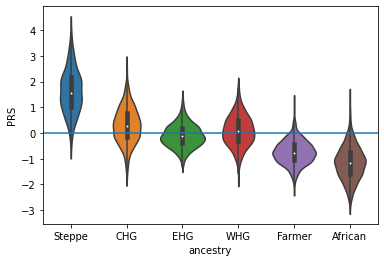

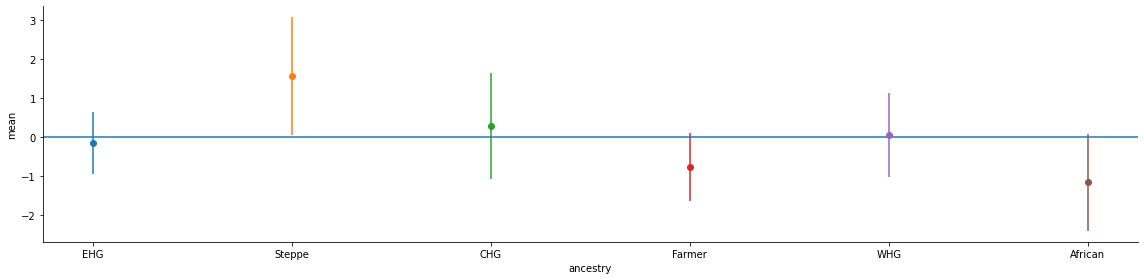

In [8]:
# Or find errors using bootstrap results directly (i.e. not assuming normal distribution)

ax = sns.violinplot(x="ancestry", y="PRS", data=results_df, inner='box')
ax.axhline(y=0)

empirical_ci_list = list()
# for anc in ['EastAsian', 'CHG', 'EHG', 'WHG', 'Farmer', 'Yamnaya', 'African']:
for anc in ['EHG', 'Steppe', 'CHG', 'Farmer', 'WHG', 'African']:
    temp = results_df.loc[results_df['ancestry']==anc]
    sorted_estimates = np.sort(np.array(temp['PRS']))
    mean = sorted_estimates[int(0.5 * boostrap_number)]
#     mean = sorted_estimates.mean()
    conf_interval = [sorted_estimates[int(0.025 * boostrap_number)], sorted_estimates[int(0.975 * boostrap_number)]]
    conf_interval_2 = [abs(x - mean) for x in conf_interval]
    empirical_ci_list.append([anc, mean, conf_interval, conf_interval_2])
empirical_ci = pd.DataFrame(empirical_ci_list, columns=['ancestry', 'mean', 'CI','CI2'])

g = sns.FacetGrid(empirical_ci, hue='ancestry', height=4, aspect=4, margin_titles = False)
g.map(plt.errorbar, 'ancestry', 'mean', 'CI2', marker="o", )
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='xx-large')
#     ax.grid()
    ax.axhline(y=0 )
    

In [ ]:
def calculate_PRS_anc(data, ancestry):
        results_df = pd.DataFrame(columns=['phenotype', 'ancestry', 'PRS'])
        maf_beta = pd.DataFrame()
        bootstrap = data
        dict_of_PRS = dict()
        maf_df_all = pd.DataFrame()
        for anc in anc_list:
            df1 = df.loc[(df[1]==phen)&(df[8]==0)&(df[2]==anc)]
            maf_list = list()
            for i in range(1,23):
                try:
                    maf_list += df1.loc[(df1[3]==i)][9].item()
                except ValueError:
                    continue
            beta_position_map['maf'] = maf_list
            maf_beta = pd.merge(bootstrap, beta_position_map)
            maf_beta['meangen'] = maf_beta['maf']*maf_beta['beta']
            dict_of_PRS[anc] = maf_beta['meangen'].sum()
            maf_df_all[anc] = maf_beta['maf']
        maf_df_all['beta'] = maf_beta['beta']
        maf_df_all['mean_freq'] = maf_df_all[anc_list].mean(axis=1)
        maf_df_all['score'] = maf_df_all['mean_freq']*(1-maf_df_all['mean_freq'])*(maf_df_all['beta']**2)
        mean_PRS = statistics.mean(list(dict_of_PRS.values()))
        varmean = maf_df_all['score'].sum()
        for anc in anc_list:
            meangen = dict_of_PRS[anc] - mean_PRS
            meangenvec = 2 * meangen / (math.sqrt(4*varmean))
            results_df = results_df.append({'phenotype':phen, 'ancestry': anc, 'PRS': meangenvec}, ignore_index=True)
        return results_df.loc[results_df['ancestry']==ancestry]['PRS'].item()
    
exclude_mhc = False
only_MHC = False

accelerated_ci_list = list()
for ancestry in anc_list:
    theta_hat = theta.loc[theta['ancestry'] == ancestry]['PRS'].item()
    I_list = []
    if exclude_mhc:
        n = beta_position_map_excluded  # exclude MHC
    elif only_MHC:
        n = beta_position_map_excluded  # only MHC
    else:
        n = beta_position_map  # include MHC
    n.reset_index(drop=True, inplace=True)
    for i in range(n.shape[0]): 
        n_len = n.shape[0]
        temp = n.iloc[n.index != i]
        theta_jack = calculate_PRS_anc(temp, ancestry)
        if theta_jack == float('+inf') or theta_jack == float('-inf'):
            print(f"* ERROR for {ancestry}, where theta_jack = {theta_jack} and i = {i}, skipping*")
            continue
        I_list.append((n_len - 1) * (theta_hat - theta_jack))
    I = np.array(I_list)
    a_hat = sum(I**3)/sum(I**2)**1.5/6
    # NB Make sure bootstrap loci cell above has been run to obtain results_df
    theta_boot = results_df.loc[results_df['ancestry'] == ancestry]['PRS'].to_numpy()
    newArr = theta_boot <= theta_hat
    newArr = newArr.astype(int)
    z0 = sp.norm.ppf(np.mean(newArr))
    a = a_hat
#     zu = np.array([sp.norm.ppf(0.085),sp.norm.ppf(0.915)])  # 83% confidence intervals 
    zu = np.array([sp.norm.ppf(0.025),sp.norm.ppf(0.975)])
    u_adjusted = sp.norm.cdf(z0 + (z0+zu)/(1-a*(z0+zu)))
    conf_interval = np.quantile(theta_boot, u_adjusted)
    conf_interval_2 = [abs(x - theta_hat) for x in conf_interval]
    accelerated_ci_list.append([ancestry, theta_hat, conf_interval, conf_interval_2])
accelerated_ci = pd.DataFrame(accelerated_ci_list, columns=['ancestry', 'mean', 'CI', 'CI2'])



In [ ]:
accelerated_ci[['c1', 'c2']] = pd.DataFrame(accelerated_ci.CI2.tolist(), index= accelerated_ci.index)
asymmetric_error = [accelerated_ci['c1'].to_numpy(), accelerated_ci['c2'].to_numpy()]
accelerated_ci.iloc[5,0] = 'Outgroup'

fig, ax = plt.subplots()
plt.errorbar(accelerated_ci['ancestry'], accelerated_ci['mean'], asymmetric_error, fmt='o', color='red',
             ecolor='lightgray', elinewidth=3, capsize=0)
fig.set_size_inches(5,5)
ax.axhline(y=0 )
ax.set_ylim([-2.5, 3.50])

# plt.title("Rheumatoid Arthritis (HLA, SNPs)")
# plt.xlabel("Ancestry")
# plt.ylabel("Ancestral Risk Score")
# plt.savefig("ARS_plots/ra_HLA.png")



,ancestry,phenotype,mean,std,sem
0,African,phenotype,-1.512147,0.061244,0.001937
1,CHG,phenotype,0.035539,0.020284,0.000641
2,EHG,phenotype,-0.033157,0.026470,0.000837
3,Farmer,phenotype,-0.581223,0.053098,0.001679
4,Steppe,phenotype,1.678488,0.018780,0.000594
5,WHG,phenotype,0.412501,0.021260,0.000672


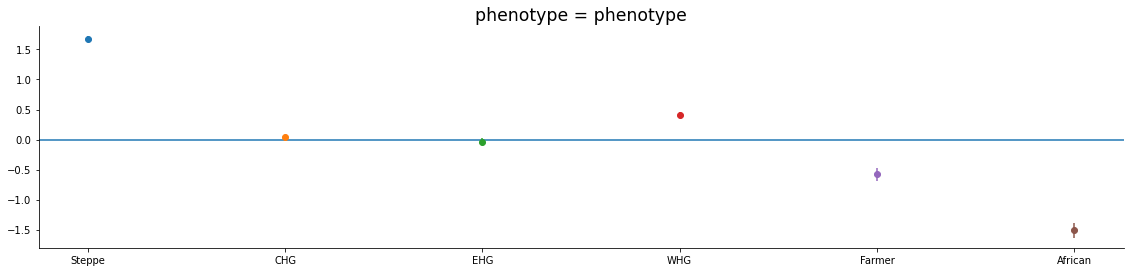

In [5]:
# Plot mean and SD using bootstrapped individuals 
df = pd.read_csv("ms_results/PRS_calculations_v4_discovery_0.7_bootstrap", sep=" ", header=None, converters={9: literal_eval, 10: literal_eval, 11: literal_eval, 12: literal_eval}) 
phen_list = ['phenotype']
anc_list = df[2].unique().tolist()
anc_list = ['African', 'WHG', 'EHG', 'CHG', 'Yamnaya','Farmer','EastAsian']
anc_list = ['Steppe', 'CHG', 'EHG', 'WHG', 'Farmer', 'African']
boostrap_number = 1000

results_df = pd.DataFrame(columns=['phenotype', 'ancestry', 'PRS'])
for phen in phen_list:
    beta_list = list()
    for i in range(1,23):
        try:
            beta_list += df.loc[(df[2]=='Farmer')&(df[8]==0)&(df[1]==phen)&(df[3]==i)][11].item()
        except ValueError:
            continue
    if len(beta_list) < 10:
        print("Warning: " + phen + " has " + str(len(beta_list)) + " SNPs")
    if not beta_list:
        continue
    df_beta = pd.DataFrame(beta_list)
    for bs in range(0,boostrap_number):
        df1 = df[(df[1]==phen)&(df[8]==bs)]
        dict_of_PRS = dict()
        maf_df_all = pd.DataFrame()
        for anc in anc_list:
            df2 = df1.loc[df1[2]==anc]
            maf_list = list()
            for i in range(1,23):
                try:
                    maf_list += df2.loc[(df2[3]==i)][10].item()
                except ValueError:
                    continue
            maf_beta = pd.DataFrame([maf_list, beta_list]).T
            maf_beta.columns = ['maf', 'beta']
            maf_beta = pd.merge(df_beta, maf_beta, left_on=0, right_on='beta') # NB sometimes duplicates SNPs if there are more than 1 beta value the same
            maf_beta['meangen'] = maf_beta['maf']*maf_beta['beta']
            dict_of_PRS[anc] = maf_beta['meangen'].sum()
            maf_df_all[anc] = maf_beta['maf']
            
        maf_df_all['beta'] = maf_beta['beta']
        maf_df_all['mean_freq'] = maf_df_all[anc_list].mean(axis=1)
        maf_df_all['score'] = maf_df_all['mean_freq']*(1-maf_df_all['mean_freq'])*(maf_df_all['beta']**2)
        mean_PRS = statistics.mean(list(dict_of_PRS.values()))
        varmean = maf_df_all['score'].sum()

        for anc in anc_list:
            meangen = dict_of_PRS[anc] - mean_PRS
            meangenvec = 2 * meangen / (math.sqrt(4*varmean))
            results_df = results_df.append({'phenotype':phen, 'ancestry': anc, 'PRS': meangenvec}, ignore_index=True)

# Find errors using bootstrap results directly (i.e. not assuming normal distribution)
ax = sns.violinplot(x="ancestry", y="PRS", data=results_df, inner='box')
ax.axhline(y=0)
empirical_ci_list = list()
for anc in anc_list:
    temp = results_df.loc[results_df['ancestry']==anc]
    sorted_estimates = np.sort(np.array(temp['PRS']))
    mean = sorted_estimates[int(0.5 * boostrap_number)]
    conf_interval = [sorted_estimates[int(0.025 * boostrap_number)], sorted_estimates[int(0.975 * boostrap_number)]]
    conf_interval_2 = [abs(x - mean) for x in conf_interval]
    empirical_ci_list.append([anc, mean, conf_interval, conf_interval_2])
empirical_ci = pd.DataFrame(empirical_ci_list, columns=['Ancestry', 'Ancestral Risk Score', 'CI','CI2'])

g = sns.FacetGrid(empirical_ci, hue='Ancestry', height=5, 
                  aspect=1, margin_titles = False)
g.map(plt.errorbar, 'Ancestry', 'Ancestral Risk Score', 'CI2', fmt='o', color='red',
             ecolor='lightgray', elinewidth=3, capsize=0)
for ax in g.axes.flat:
    ax.set_title("Multiple Sclerosis (all, individuals)")
    ax.set_ylim([-2, 2])
    ax.axhline(y=0 )


,Ancestry,Ancestral Risk Score,CI,CI2
0,Steppe,-0.057642,"[-0.07582051384318117, -0.04068974099486995]","[0.01817831720662578, 0.01695245564168544]"
1,CHG,-0.304848,"[-0.31882354474549046, -0.29134367397696953]","[0.013975089301564325, 0.013504781466956606]"
2,EHG,-0.461221,"[-0.47331114151243536, -0.44776784088103116]","[0.012090163776493967, 0.01345313685491023]"
3,WHG,-1.189206,"[-1.200868948855151, -1.1765473155485104]","[0.01166343065018971, 0.01265820265645079]"
4,Farmer,0.063817,"[0.047715319818289026, 0.07948466001890427]","[0.016101916701215663, 0.015667423499399577]"
5,African,1.948899,"[1.9018185096236115, 1.9962201261857497]","[0.047080434725788045, 0.047321181836350146]"


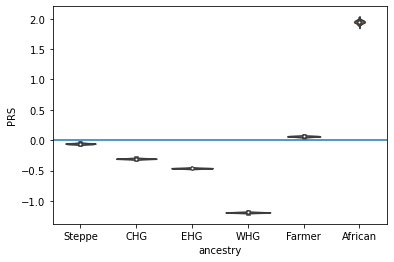

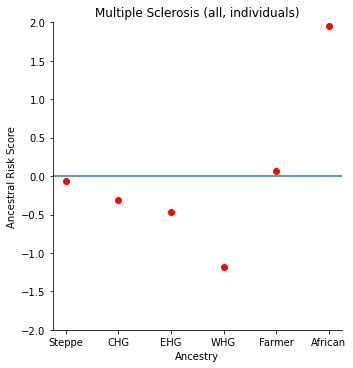

In [38]:
# Find errors using bootstrap results directly (i.e. not assuming normal distribution)
ax = sns.violinplot(x="ancestry", y="PRS", data=results_df, inner='box')
ax.axhline(y=0)

empirical_ci_list = list()
for anc in anc_list:
    temp = results_df.loc[results_df['ancestry']==anc]
    sorted_estimates = np.sort(np.array(temp['PRS']))
    mean = sorted_estimates[int(0.5 * boostrap_number)]
#     mean = sorted_estimates.mean()
    conf_interval = [sorted_estimates[int(0.025 * boostrap_number)], sorted_estimates[int(0.975 * boostrap_number)]]
    conf_interval_2 = [abs(x - mean) for x in conf_interval]
    empirical_ci_list.append([anc, mean, conf_interval, conf_interval_2])
empirical_ci = pd.DataFrame(empirical_ci_list, columns=['Ancestry', 'Ancestral Risk Score', 'CI','CI2'])
display(empirical_ci)

g = sns.FacetGrid(empirical_ci, hue='Ancestry', height=5, 
                  aspect=1, margin_titles = False)
g.map(plt.errorbar, 'Ancestry', 'Ancestral Risk Score', 'CI2', fmt='o', color='red',
             ecolor='lightgray', elinewidth=3, capsize=0)
for ax in g.axes.flat:
    ax.set_title("Multiple Sclerosis (all, individuals)")
    ax.set_ylim([-2, 2])
#     ax.grid()
    ax.axhline(y=0 )
# g.savefig("ARS_plots/ms_all_inds.png")